# **PROJECT: Xây dựng hệ thống nhận diện ngôn ngữ ký hiệu tay sử dụng học sâu**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1. Tải dữ liệu và nhập thư viện**

## **Tải dữ liệu**

In [ ]:
%%capture
!unzip /content/drive/MyDrive/BaitaplonDeep/asl_alphabet_test.zip -d /content/dataset/
!unzip /content/drive/MyDrive/BaitaplonDeep/asl_alphabet_train.zip -d /content/dataset/

## **Nhập các thư viện cần thiết**

In [ ]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split


# **2. Chuẩn bị và tiền xử lý dữ liệu**

## **Config**

In [ ]:
TRAINING_DIR = '/content/dataset/asl_alphabet_train'
TEST_DIR = '/content/dataset/asl_alphabet_test'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = 'cnn_asl_model.keras'

## **Data visualize**

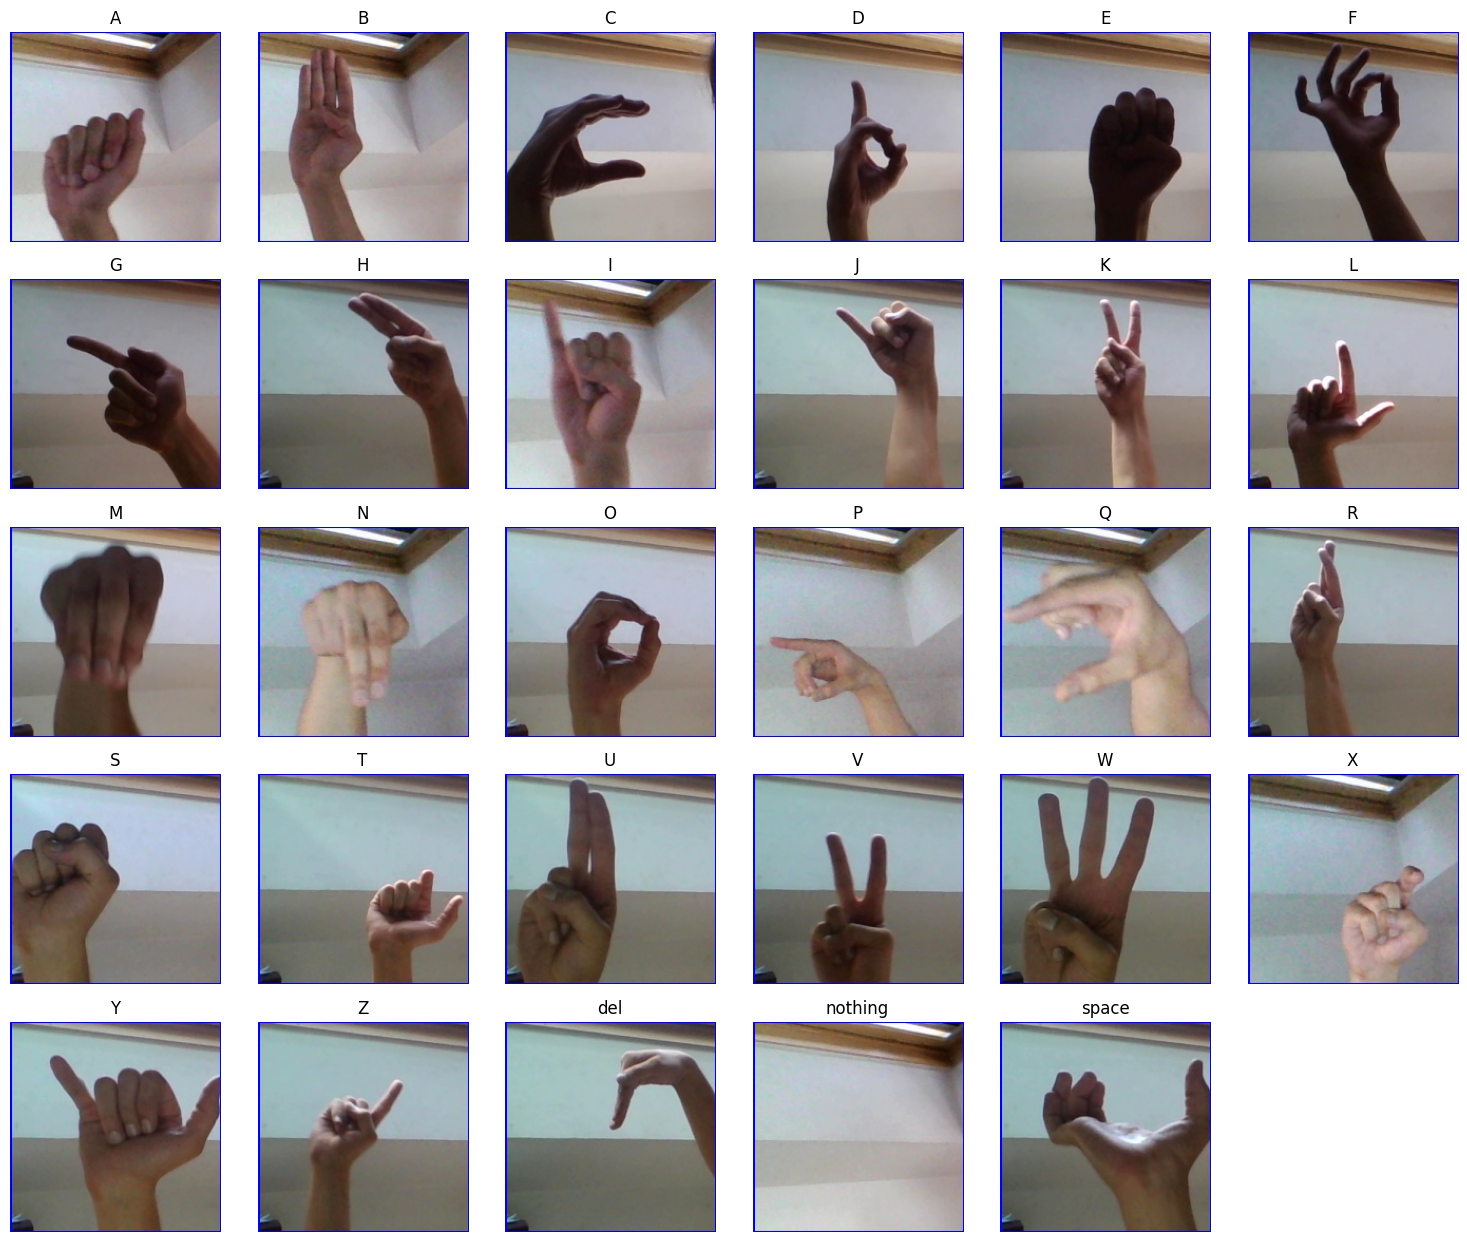

In [ ]:
def display_one_example_per_class(train_dir):
    class_names = sorted(os.listdir(TRAINING_DIR))
    num_classes = len(class_names)
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(TRAINING_DIR, class_name)
        if os.path.isdir(class_dir):
            image_files = glob(os.path.join(class_dir, "*.jpg"))
            if not image_files:
                continue
            selected_image = random.choice(image_files)
            img = Image.open(selected_image)


            plt.subplot(int(num_classes ** 0.5) + 1, int(num_classes ** 0.5) + 1, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_one_example_per_class(TRAINING_DIR)


## **Tiền xử lý dữ liệu**

In [ ]:
import os
from glob import glob
import pandas as pd

CLASSES = sorted(os.listdir(TRAINING_DIR))

list_path = []
list_labels = []


for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)


metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})


print(metadata.head())
print(f"Tổng số ảnh: {len(metadata)}")


                                        image_path label
0   /content/dataset/asl_alphabet_train/A/A631.jpg     A
1  /content/dataset/asl_alphabet_train/A/A1389.jpg     A
2   /content/dataset/asl_alphabet_train/A/A242.jpg     A
3   /content/dataset/asl_alphabet_train/A/A224.jpg     A
4   /content/dataset/asl_alphabet_train/A/A940.jpg     A
Tổng số ảnh: 43500


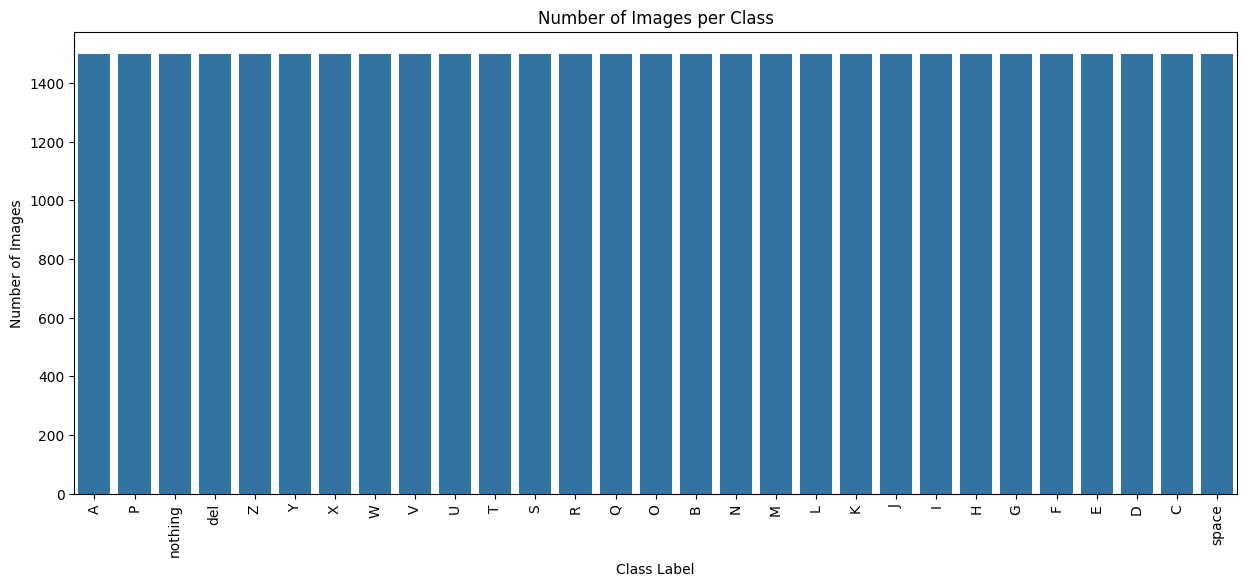

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of images per class
class_counts = metadata['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(15, 6))
sns.countplot(x='label', data=metadata, order=class_counts.index)
plt.xticks(rotation=90)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [ ]:
# Tách thành 3 tập train, validation, test theo tỉ lệ như config

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

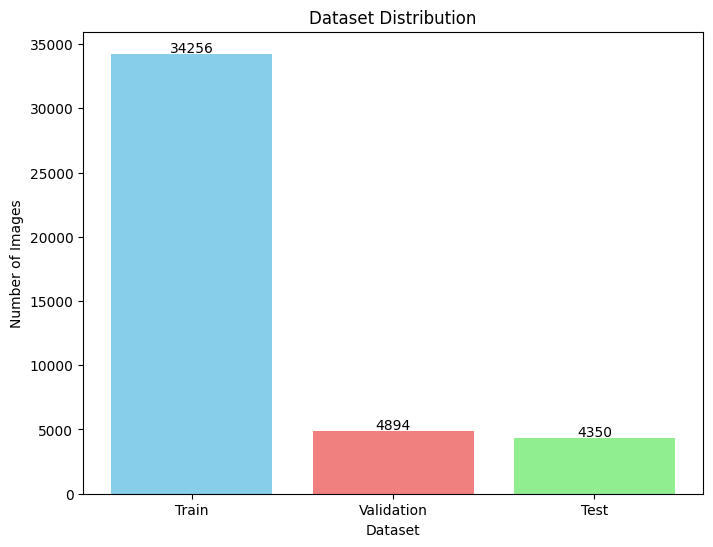

In [ ]:
import matplotlib.pyplot as plt

train_count = len(data_train)
val_count = len(data_val)
test_count = len(data_test)

labels = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Dataset Distribution')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')

for i, v in enumerate(counts):
    plt.text(i, v + 100, str(v), ha='center')

plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 34256 validated image filenames belonging to 29 classes.
Found 4894 validated image filenames belonging to 29 classes.
Found 4894 validated image filenames belonging to 29 classes.


# **3. Xây dựng mô hình**


## **ResNet 50**

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_res = ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
for layer in base_model_res.layers:
    layer.trainable = False
x = base_model_res.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model_res = Model(inputs=base_model_res.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_res.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,715,613 (98.10 MB)

 Trainable params: 2,127,901 (8.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
train_history = model_res.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


536/536 ━━━━━━━━━━━━━━━━━━━━ 437s 780ms/step - accuracy: 0.0478 - loss: 3.3797 - val_accuracy: 0.0942 - val_loss: 3.0820
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 418s 752ms/step - accuracy: 0.1057 - loss: 3.0218 - val_accuracy: 0.1757 - val_loss: 2.8626
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 442s 749ms/step - accuracy: 0.1567 - loss: 2.8152 - val_accuracy: 0.2041 - val_loss: 2.6636
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 406s 750ms/step - accuracy: 0.2028 - loss: 2.6373 - val_accuracy: 0.1972 - val_loss: 2.6082
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 444s 754ms/step - accuracy: 0.2306 - loss: 2.5071 - val_accuracy: 0.2685 - val_loss: 2.4170


In [ ]:
predictions = model_res.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4894/4894 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step
Evaluate Test Accuracy: 0.27%


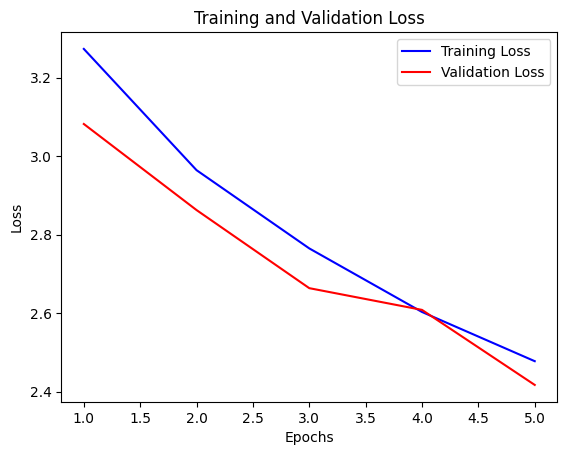

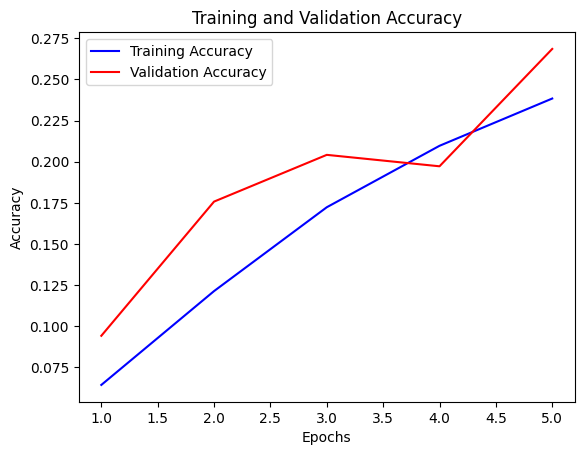

In [ ]:
# Access the history of loss and accuracy from train_history
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']  # Validation loss
accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy'] # Validation accuracy

# Plot the training and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **EfficientNet**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model_eff = EfficientNetB0(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
for layer in base_model_eff.layers:
    layer.trainable = False
x = base_model_eff.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(29, activation='softmax')(x)

# Tạo mô hình hoàn chỉnh
model_eff = Model(inputs=base_model_eff.input, outputs=predictions)
model_eff = Model(inputs=base_model_eff.input, outputs=predictions)

model_eff.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_eff.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 200, 200, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 200, 200, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 200, 200, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 201, 201, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 100, 100, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 100, 100, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 100, 100, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 100, 100, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 100, 100, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 100, 100, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,720,320 (18.01 MB)

 Trainable params: 670,749 (2.56 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
train_history = model_eff.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 441s 773ms/step - accuracy: 0.0355 - loss: 3.3823 - val_accuracy: 0.0343 - val_loss: 3.3673
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 400s 738ms/step - accuracy: 0.0339 - loss: 3.3682 - val_accuracy: 0.0343 - val_loss: 3.3673
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 401s 740ms/step - accuracy: 0.0334 - loss: 3.3677 - val_accuracy: 0.0345 - val_loss: 3.3673
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 440s 737ms/step - accuracy: 0.0334 - loss: 3.3676 - val_accuracy: 0.0345 - val_loss: 3.3675
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 392s 722ms/step - accuracy: 0.0341 - loss: 3.3677 - val_accuracy: 0.0343 - val_loss: 3.3673


In [ ]:
predictions = model_eff.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

4894/4894 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step
Evaluate Test Accuracy: 0.03%


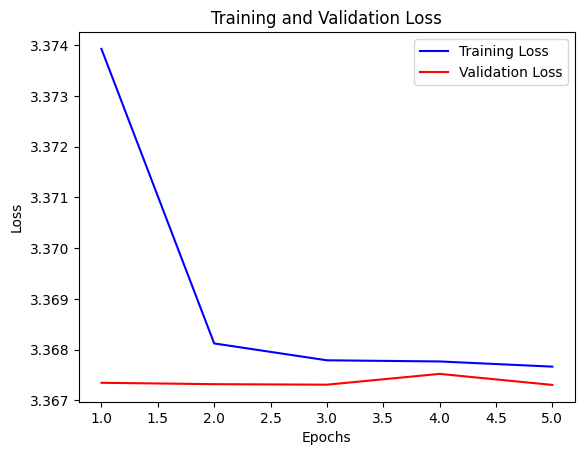

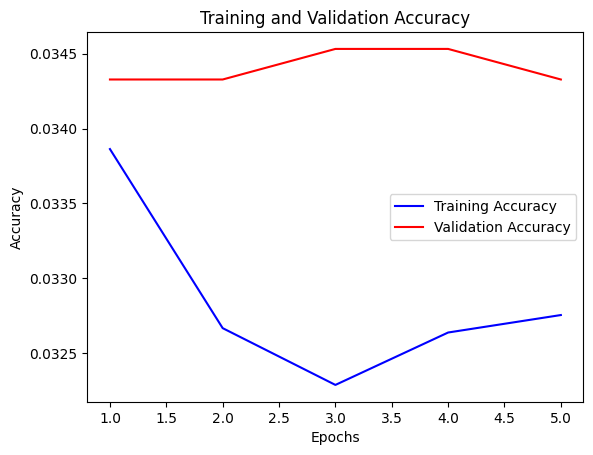

In [ ]:
# Access the history of loss and accuracy from train_history
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']  # Validation loss
accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy'] # Validation accuracy

# Plot the training and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





## **Transfer learning using Inception V3 Network**

In [ ]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Huấn luyện mô hình InceptionV3**

**Looking at the final model:**

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 99, 99, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 99, 99, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 99, 99, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 97, 97, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 97, 97, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 97, 97, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 97, 97, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 97, 97, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 97, 97, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 48, 48, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 48, 48, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 48, 48, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 48, 48, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,930,685 (91.29 MB)

 Trainable params: 2,127,901 (8.12 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

**Setting up a callback funtion in order to stop training at a particular threshold:**

**Fit model :**

In [ ]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 434s 780ms/step - accuracy: 0.7640 - loss: 0.9571 - val_accuracy: 0.8735 - val_loss: 0.4014
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 412s 760ms/step - accuracy: 0.9511 - loss: 0.1525 - val_accuracy: 0.9273 - val_loss: 0.2241
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 746ms/step - accuracy: 0.9630 - loss: 0.1114 - val_accuracy: 0.9383 - val_loss: 0.1857
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 408s 754ms/step - accuracy: 0.9766 - loss: 0.0742 - val_accuracy: 0.9581 - val_loss: 0.1305
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 747ms/step - accuracy: 0.9701 - loss: 0.0891 - val_accuracy: 0.9268 - val_loss: 0.2493


## **Fine-Tuning**

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 99, 99, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 99, 99, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 99, 99, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 97, 97, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 97, 97, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 97, 97, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 97, 97, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 97, 97, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 97, 97, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 48, 48, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 48, 48, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 48, 48, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 48, 48, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,930,685 (91.29 MB)

 Trainable params: 13,242,781 (50.52 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 440s 773ms/step - accuracy: 0.8324 - loss: 0.5951 - val_accuracy: 0.9383 - val_loss: 0.2202
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 402s 742ms/step - accuracy: 0.9732 - loss: 0.1115 - val_accuracy: 0.9624 - val_loss: 0.1435
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 403s 741ms/step - accuracy: 0.9840 - loss: 0.0699 - val_accuracy: 0.9722 - val_loss: 0.1086
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 746ms/step - accuracy: 0.9890 - loss: 0.0506 - val_accuracy: 0.9759 - val_loss: 0.0904
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 402s 743ms/step - accuracy: 0.9914 - loss: 0.0399 - val_accuracy: 0.9794 - val_loss: 0.0754


## **Lưu mô hình**

**As we were satisfied with our results we save our model:**

In [ ]:
# Saving the model
model.save(MODEL_PATH)

# **4. Đánh giá mô hình**

## **Model Testing**

In [ ]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

4894/4894 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step
Evaluate Test Accuracy: 0.98%


## **Training Loss and Metrics**

In [ ]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)


In [ ]:
visualize_train_val(train_history)

### Fine-tune

In [ ]:
visualize_train_val(fine_tune_history)

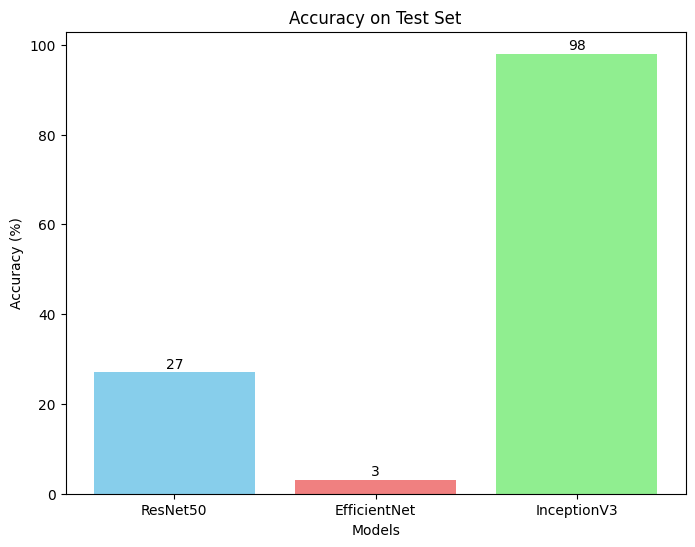

In [ ]:

import matplotlib.pyplot as plt

models = ['ResNet50', 'EfficientNet', 'InceptionV3']
accuracy = [27, 3, 98]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Accuracy on Test Set')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

for i, v in enumerate(accuracy):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

## **Confusion Matrix**

In [ ]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

## **Kiểm tra ảnh trên thực tế**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
D


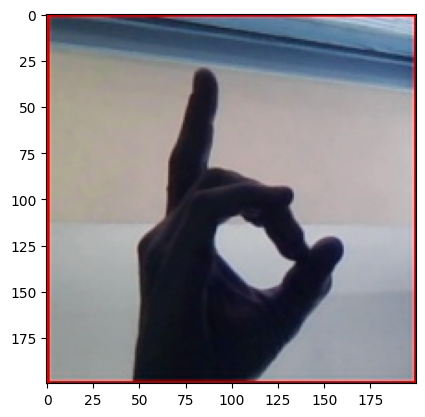

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_location = '/content/dataset/asl_alphabet_test/D_test.jpg'

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200

# Check if the image file exists
import os
if not os.path.exists(image_location):
    raise FileNotFoundError(f"Image file not found at: {image_location}")

img = cv2.imread(image_location)

# Check if the image was loaded successfully
if img is None:
    raise IOError(f"Failed to load image from: {image_location}")

img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]

print(predicted)